<a href="https://colab.research.google.com/github/keonju2/2022_GDSC_DL/blob/main/DL_10%EC%A3%BC%EC%B0%A8_%EA%B3%B5%EC%9C%A0Ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Architecture

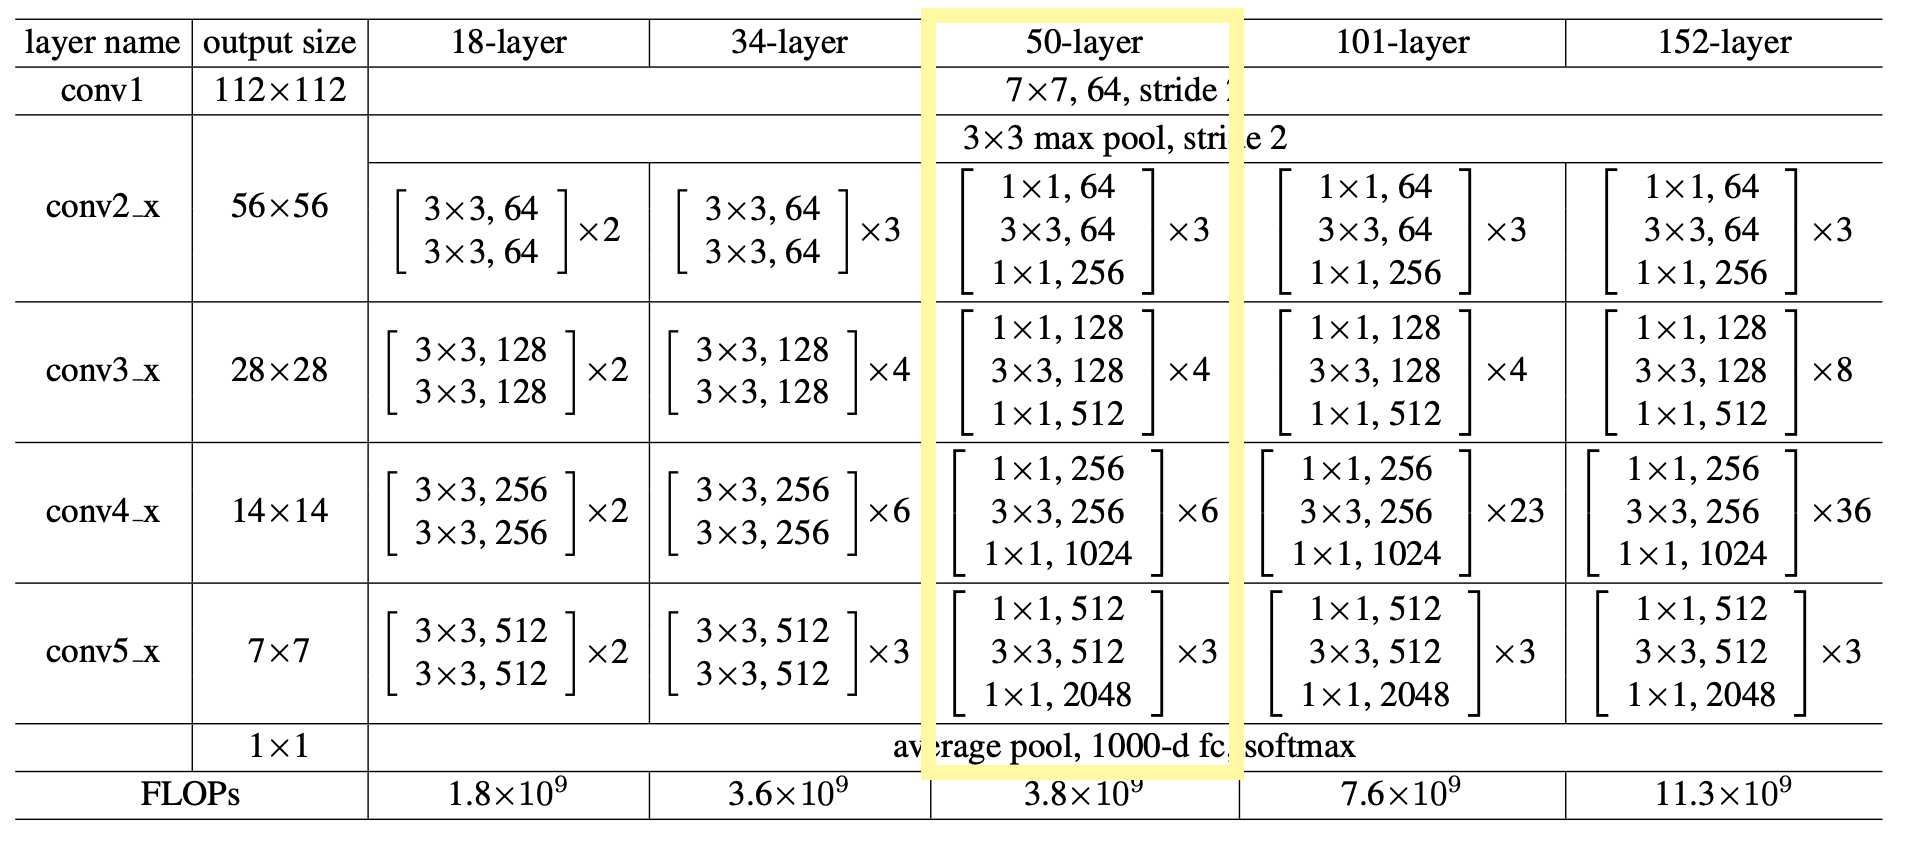

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from sklearn.model_selection import train_test_split
import tqdm

In [27]:
# model
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4

        # 1x1 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        # relu
        self.relu = nn.ReLU()

        # identity mapping
        self.identity_downsample = identity_downsample


    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

        x+= identity


        x = self.relu(x)

        return x

# ResNet 50 Architecture: 3 4 6 3
class ResNet(nn.Module): 
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # layer_name = conv2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.layer(block, layers[0], out_channels=64, stride=1)

        # layer_name = conv3
        self.layer2 = self.layer(block, layers[1], out_channels=128, stride=2)

        # layer_name = conv4
        self.layer3 = self.layer(block, layers[2], out_channels=256, stride=2)

        # layer_name = conv5
        self.layer4 = self.layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, num_classes)

    # 50개의 layer를 다 쌓을 수 없으니...
    def layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None

        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))       
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # ResNet 전
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)       

        # ResNet 중
        x = self.layer1(x) # 8
        x = self.layer2(x) 
        x = self.layer3(x) 
        x = self.layer4(x)



        # ResNet 후
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # Linear layer에 넣어주기 위해 reshape
        y = self.fc(x)


        return y

# 드디어 ResNet
def ResNet50(img_channels=3, num_classes=10):
    return ResNet(block, [3,4,6,3], img_channels, num_classes)

In [3]:
# data transforms

transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [6]:
# data load
train = datasets.CIFAR10(root='ciFAR10_data/', 
                         train=True, 
                         download=True, 
                         transform=transform_train)
test = datasets.CIFAR10(root='ciFAR10_data/', 
                        train=False, 
                        download=True, 
                        transform=transform_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ciFAR10_data/cifar-10-python.tar.gz to ciFAR10_data/
Files already downloaded and verified


In [15]:
# data split
from torch.utils.data import Subset

train_indices, val_indices, _, _ = train_test_split(range(len(train)), train.targets, test_size=.1)
train_set = Subset(train, train_indices)
val_set = Subset(train, val_indices)

In [16]:
# dataloader
batch_size = int(128)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2)
valloder = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
# cifar10
# cifar10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
# model
model = ResNet50().cuda()
num_parmas = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The Number of params of model: ', num_parmas)

# criterion & optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.15, momentum=0.9, weight_decay =1e-4)

# decay_epoch
decay_epoch = [32000, 48000]
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)

The Number of params of model:  19760010


In [29]:
# train
model.train()
steps = 0
total = 0 
correct = 0
for epoch in range(182):
    epoch_loss = 0.0
    for i, data in enumerate(tqdm.tqdm(trainloader, desc=f'{epoch+1} epoch')):
        steps+=1
        inputs, labels = data
        total += labels.size(0)
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs).cuda()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        schedular.step()
        _, predict = outputs.max(1)
        correct += predict.eq(labels).sum().item()
        epoch_loss += loss.item()
        if steps == 64000:
            break
    if steps == 64000:
        break
    training_loss = epoch_loss/len(trainloader)
    wandb.log({"loss": training_loss})
    print('Training loss: ', training_loss)
    print('Accuracy(Training): {} % '.format(100.*correct/total))
print('Finished Training')

1 epoch:   0%|          | 0/352 [00:06<?, ?it/s]


RuntimeError: ignored

In [ ]:
# Validation 
model.eval()
total = 0
correct = 0
with torch.no_grad():
    epoch_loss=0
    for idx, data in enumerate(tqdm.tqdm(valloder, desc=f'{epoch+1} epoch')):
        inputs, labels = data
        total += labels.size(0)
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs).cuda()
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        _, predict = outputs.max(1)
        correct += predict.eq(labels).sum().item()
    loss = epoch_loss/len(valloder)
    accuracy = outputs
    print('Validation loss: ', loss)
    print('Accuracy(Validation): ', 100.*correct/total)